# Importing Libraries

In [48]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy import signal
from mne.filter import notch_filter
from mne.datasets import sample

from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs


#https://www.physionet.org/pn4/eegmmidb/

%matplotlib inline  


# Reading raw data and picking the relevant channels

In [49]:
#raw = mne.io.read_raw_ctf('MNI0041_MEGs0003_resting_20130416_03_AUX.ds', preload=True)


In [59]:
edf_fnames = ["S001R02.edf", "S002R02.edf", "S003R02.edf"]
raws = [mne.io.read_raw_edf(fname, preload=True) for fname in edf_fnames]

Extracting edf Parameters from S001R02.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from S002R02.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.
Extracting edf Parameters from S003R02.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Ready.


In [60]:
for i in raws:
    print(i.ch_names)
    #print(raw.info)
    print(i.info['chs'][0]['loc'])
    for x in i.ch_names:
        str = x.replace(".", "")
        #print(str)
        i.rename_channels(mapping={x:str})
    print (i.ch_names)
    print(i.info['chs'][0]['loc'])

['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..', 'STI 014']
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz', 'STI 014'

In [79]:
for raw in raws:
    print (raw)
    raw.filter(None, 50., h_trans_bandwidth='auto', filter_length='auto',
               phase='zero')
    raw.filter(1, 40, n_jobs=2)  # 1Hz high pass is often helpful for fitting ICA
    
    
    picks_meg = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                               stim=False, exclude='bads')
    montage = mne.channels.read_montage('standard_1005')
    print(montage)
    raw.set_montage(montage)

<RawEDF  |  S001R02.edf, n_channels x n_times : 65 x 9760 (61.0 sec), ~4.9 MB, data loaded>
Setting up low-pass filter at 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 84 samples (0.525 sec) selected
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1056 samples (6.600 sec) selected
<Montage | standard_1005 - 346 channels: LPA, RPA, Nz ...>
<RawEDF  |  S002R02.edf, n_channels x n_times : 65 x 9760 (61.0 sec), ~4.9 MB, data loaded>
Setting up low-pass filter at 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 84 samples (0.525 sec) selected


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    7.3s finished


Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1056 samples (6.600 sec) selected
<Montage | standard_1005 - 346 channels: LPA, RPA, Nz ...>
<RawEDF  |  S003R02.edf, n_channels x n_times : 65 x 9760 (61.0 sec), ~4.9 MB, data loaded>
Setting up low-pass filter at 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 84 samples (0.525 sec) selected
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1056 samples (6.600 sec) selected


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    1.8s finished


<Montage | standard_1005 - 346 channels: LPA, RPA, Nz ...>


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  64 out of  64 | elapsed:    4.7s finished


# Checking what the actual data looks like

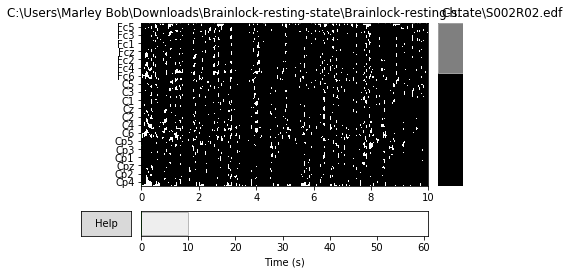

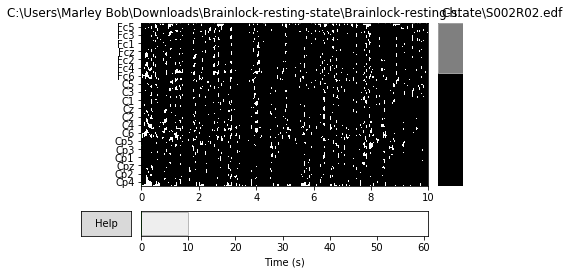

In [53]:
raws[0].plot()

In [65]:
icas = [ICA(n_components=25, method='fastica', random_state=23) for i in raws]
#ica = ICA(n_components=25, method='fastica', random_state=23)
print(icas[0])
print(icas[1])
print(icas[2])

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


In [80]:
reject = dict(mag=5e-12, grad=4000e-13)
#icas[0].fit(raw, picks=picks_meg, decim=3, reject=reject)
num = 0
for ica in icas:
    ica.fit(raws[num], picks=picks_meg, decim=3, reject=reject)
    print(ica)
    num = num + 1
    print (num)

Fitting ICA to data using 64 channels. 
Please be patient, this may take some time
Selection by number: 25 components
<ICA  |  raw data decomposition, fit (fastica): 3210 samples, 25 components, channels used: "eeg">
1
Fitting ICA to data using 64 channels. 
Please be patient, this may take some time
Selection by number: 25 components


c:\users\marley bob\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


<ICA  |  raw data decomposition, fit (fastica): 3210 samples, 25 components, channels used: "eeg">
2
Fitting ICA to data using 64 channels. 
Please be patient, this may take some time
Selection by number: 25 components
<ICA  |  raw data decomposition, fit (fastica): 3210 samples, 25 components, channels used: "eeg">
3


# Plotting Raw Data

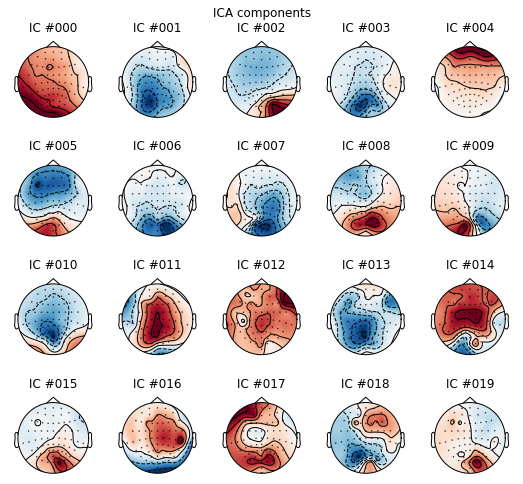

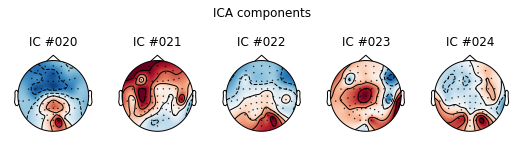

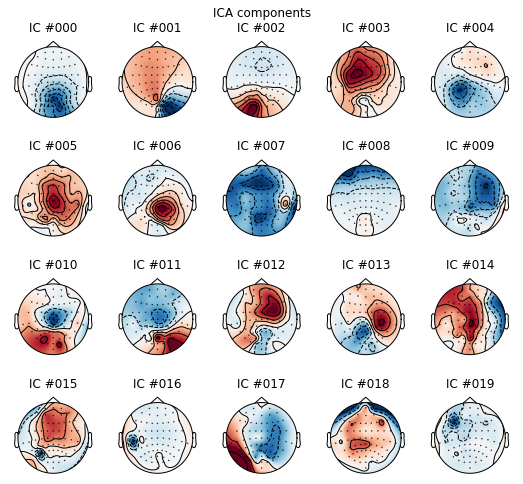

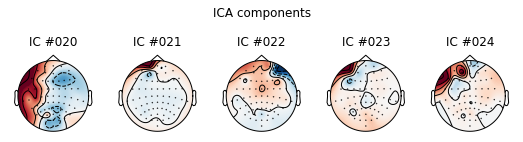

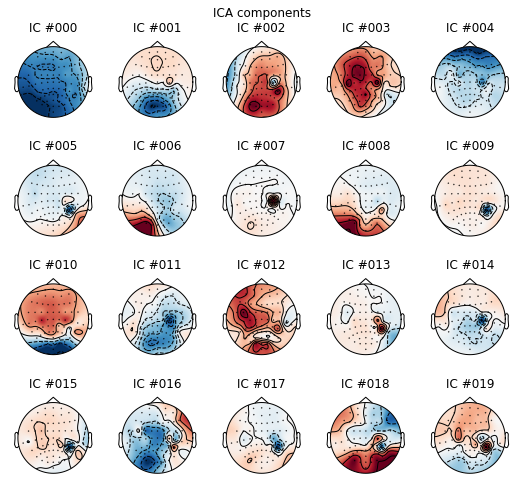

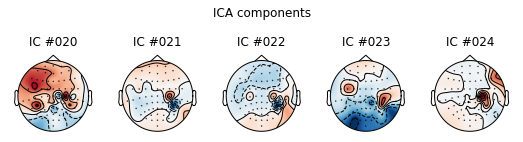

In [81]:
for ica in icas:
    ica.plot_components()

# Running FastICA and PCA on the transposed data

In [57]:
ica = FastICA()
S_ = ica.fit_transform(X)
A_ = ica.mixing_

NameError: name 'FastICA' is not defined

In [ ]:
pca = PCA()
H = pca.fit_transform(X)

# Plotting the ICA

In [ ]:
plt.figure()
plt.plot(S_,"g")
plt.plot(X)
plt.show()

In [ ]:
S_.shape

In [ ]:
#fft 
import scipy 
from scipy import fft


In [ ]:
X.shape

In [ ]:
f = scipy.fft(X)
f_abs = abs(f)

t = scipy.linspace(0,4000,len(f_abs))
freqs = scipy.fftpack.fftfreq(f_abs.size, t[1]-t[0])


In [ ]:
#plt.plot(X)
#plt.plot(f_abs)
plt.plot(freqs,20*scipy.log10(f),'x')

In [ ]:
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)